Scanning Probe Microscopy in 3D
============================

Scanning Probe Microscopy (SPM) is an imaging technique that provides 2D images with nanoscale spatial resolution. Scalpel SPM (see <cite data-cite="celano2017nanoscale">Celano et al. (2017)</cite>) is an extension of this technique to 3D imaging, by removing layers of the scanned material to image individual slices. It has applications in the study of nanoelectronic devices, where it is used to improve the understanding of the device physics, operation and process development.

During the acquisition process, slight misalignments can occur between the individual slices. These misalignments have to be estimated and taken into account when reconstructing the final 3D image. The slices can be aligned using image warping, and the misalignment can be estimated by minimizing an objective function that penalizes misalignment in the 3D image.


In [1]:
import numpy as np
import pylops
from matplotlib import pyplot as plt

import imwip

We start by loading a dataset obtained from RPM3D (Rapid Probe Microscope 3D, <cite data-cite="celano2021innovative">Celano et al. (2021)</cite>). This is a stack of 30 (possibly) misaligned 2D images of shape 512 x 512:

In [2]:
spm_data = np.load("SPM_data.npy")
spm_data.shape

(30, 512, 512)

This is what these images look like:

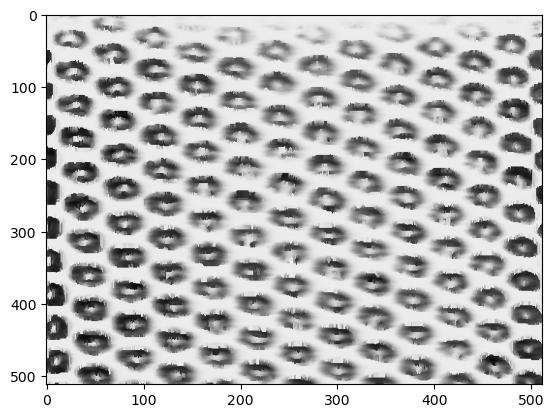

In [3]:
plt.imshow(spm_data[15], aspect="auto", cmap="gray")

On a vertical slice, the misalignment can be observed:

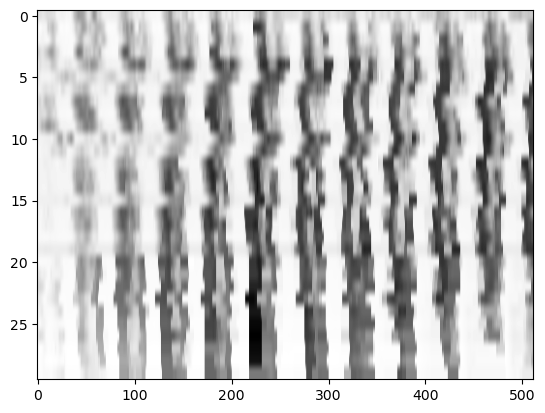

In [4]:
plt.imshow(spm_data[:, :, 256], aspect="auto", cmap="gray")

The objective function
--------------------------------

Call the original 3D image $x$, which is a stack of misaligned slices:

$$x = \begin{bmatrix}
x_1 \\
x_2 \\
\vdots\\
x_n
\end{bmatrix}
$$

We are looking for a vector $t$ of translation parameters such that

$$
M(t)x=\begin{bmatrix}
T(t_1) & 0 & \cdots & 0 \\
0 & T(t_2) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & T(t_n)
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
\vdots\\
x_n
\end{bmatrix}
$$

is better aligned, where the operators $T(t_i)$ translate individual slices.

A suitible objective function is the vertical total variation, i.e. the norm image gradient in the vertical direction:

$f(t) = \frac{1}{2} \lVert \nabla_z M(t)x\rVert^2$

In [5]:
x = spm_data.ravel()
im_shape = spm_data.shape[1:]
T = lambda ti: imwip.AffineWarpingOperator2D(im_shape, translation=ti)
M = lambda t: pylops.BlockDiag([T(ti) for ti in t.reshape(-1, 2)])
D = imwip.GradientOperator3DX(spm_data.shape)

In [6]:
def f(t):
    DMx = D @ M(t) @ x
    return 1/2 * np.dot(DMx, DMx)

Solving
-----------

More important for the solver is the gradient of this objective function towards $t$:

$\nabla f(t) = \left(\frac{d}{dt}M(t)x\right)^T\nabla_z^T(\nabla_z M(t)x)$

In [7]:
def grad_f(t):
    DMx = D @ M(t) @ x
    return imwip.diff(M(t), x, to="translation").T @ (D.T @ DMx)

In [8]:
t0 = np.zeros(spm_data.shape[0]*2)
t = imwip.barzilai_borwein(grad_f, x0=t0, max_iter=30, verbose=True)
rec = (M(t) @ x).reshape(spm_data.shape)

100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


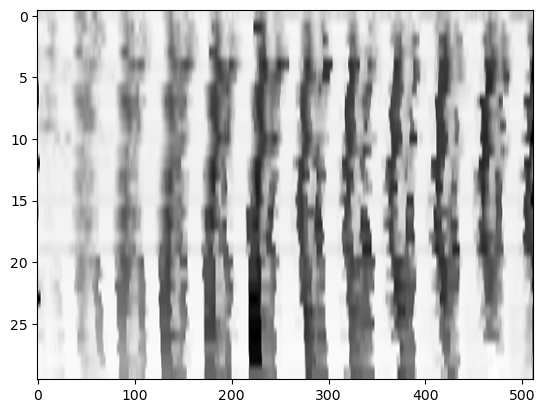

In [9]:
plt.imshow(np.clip(rec[:, :, 256], 0, 1), aspect="auto", cmap="gray")

This is an improvement, but it can still be aligned better. A typical problem with alignement is getting stuck in local minima of the objective function. These local minima can be avoided by repeating the optimization at multiple resolutions:

In [10]:
from skimage.transform import downscale_local_mean

t = np.zeros(spm_data.shape[0]*2)
for factor, iters in [(8, 200), (4, 150), (2, 30), (1, 30)]:
    scaled = downscale_local_mean(spm_data, (1, factor, factor))
    x = scaled.ravel()
    im_shape = scaled[0].shape
    D = imwip.GradientOperator3DX(scaled.shape)
    t = imwip.barzilai_borwein(grad_f, x0=t*2, max_iter=iters, verbose=True)
rec = (M(t) @ x).reshape(spm_data.shape)

100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.29it/s]


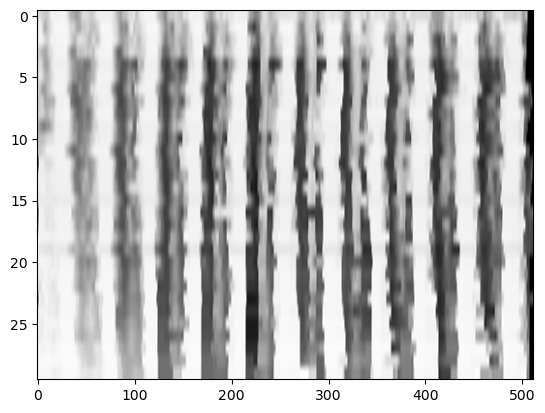

In [11]:
plt.imshow(np.clip(rec[:, :, 256], 0, 1), aspect="auto", cmap="gray")